# Нейросетевые модели поиска. Часть II. Переранжирование.
## Домашнее задание

В этом задании вам предстоит обучить модели переранжирования с архитектурой cross-encoder и bi-encoder на датасете [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). За его решение можно получить до 10 баллов, а также еще 10 бонусных за выполнение дополнительных заданий.

**Вам надо:**

- Форкнуть эту репу;
- Создать бранч, в котором вы дальше будете работать;
- Выполнить все или часть заданий ноутбука;
- Запушить ваш бранч и поставить Pull Request.

Проверяющий счекаутит вашу бранчу и проверит работу.

**Замечания:**

- При выполнении задания можете использовать код из соответствующего семинара;
- Вам предстоит сделать как минимум 2 обучения (а при выполнении дополнительных заданий и того больше), постарайтесь переиспользовать код и минимизировать копипасты;
- Старайтесь писать чистый и понятный код, не оставляйте в ноутбуке лишний мусор (выводы ячеек с pip install, ненужный закомментированный код и т.д.);
- При сдаче дз сохраните выходы ячеек с логами обучения и графиками. Если для построения графиков вы использовали tensorboard, то вставьте графики в ноутбук в виде скриншотов;
- Итоговый ноутбук должен быть работоспособен, то есть проверяющий должен иметь возможность запустить все его ячейки в том порядке, в котором они распологаются в ноутбуке, и получить результаты, аналогичные вашим.


### Данные [1 балл]

Скачайте и распакуйте датасет [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). Архив содержит следующие файлы (формат аналогичен MS MARCO):
* vkmarco-docs.tsv - tsv с текстами документов;
* vkmarco-doctrain-queries.tsv - tsv с текстами запросов;
* vkmarco-doctrain-qrels.tsv - tsv с оценками релевантности запроса и документа;
* Аналогичный набор файлов для валидации.

Загрузите данные трейна и валидации в pandas.DataFrame так, чтобы он содержал следующие колонки:
* qid - id запроса;
* query - текст запроса;
* text - текст документа;
* label - оценка релевантности запроса и документа.

# Изучение данных и создание эталонного датафрейма
Клетки приведенные ниже содержать исследования того, как хранятся исходные данные и код склеивания отдельных датафреймов в один в запрашиваемом виде.
Эти клетки могут быть не выполнены, тк считываение, создание и _сохранение_ общего датафрейма встроено в класс `VKMarcoDataModule`в метод `prepare_data()`.

In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

folder = "/kaggle/input/vk-marco/vkmarcoranking-v1-document"
qrels_file = f'{folder}/vkmarco-doctrain-qrels.tsv'
docs_file = f'{folder}/vkmarco-docs.tsv'
queries_file = f'{folder}/vkmarco-doctrain-queries.tsv'

test_qrels_file = f'{folder}/vkmarco-docdev-qrels.tsv'
test_docs_file = f'{folder}/vkmarco-docs-lookup.tsv'
test_queries_file = f'{folder}/vkmarco-docdev-queries.tsv'


In [2]:
!ls {folder}

vkmarco-docdev-qrels.tsv    vkmarco-docs.tsv
vkmarco-docdev-queries.tsv  vkmarco-doctrain-qrels.tsv
vkmarco-docs-lookup.tsv     vkmarco-doctrain-queries.tsv


In [3]:
!head -n 5 {test_qrels_file}

5 0 D000000067 2
5 0 D000000068 2
5 0 D000000069 2
5 0 D000000070 1
5 0 D000000071 1


In [4]:
!head -n 1 {docs_file}

D000000001	zvuk.top/tracks/%D0%B4%D0%BE%D0%BC-raim-feat-artur-adil	Дом raim feat artur adil музыка в MP3 🎵 – скачать бесплатно, слушать музыку дом raim feat artur adil - 1 песен/песни онлайн на Zvuk.top!	Скачивай и слушай 🎧 raim дом o2 2018 на Zvuk.top! Новинки месяца Bakhtin Блондинка Олег Газманов Артефакты Mosovich feat Batrai Life of Lie Тёма Балалайкин Иванова Sunami Улетай To-ma and Джаро & Ханза Не плачь Pilo Sugar Powder Tattooin Драконы Call Me Karizma feat Astrus Burn Godok Let Me Use The Gun Жанры и настроения Сборники Исполнители Marcus Tenshi Mehmet Gureli ВИА Спецназ Sami Yusuf Найк Борзов Nikitata Рекомендуем новинки Онлайн радио Рекорд (Record Dance radio) Альбомы Oliver Sim - Hideous Bastard Топ 100 лучших русских песен Песни Муз ТВ Русское Радио Слава и Анна Семенович Бумеранг Юлия Савичева Майский дождь Jony Титры Emin На обратной стороне Дмитрий Маликов Ночь расскажет Anna Asti По барам Стас Костюшкин Останешься Ханна Море Filatov & Karas Движ Сергей Лазарев Танцуй 

In [5]:
!head -n 5 {queries_file}

1857	акватекс электромаш в москве умывальник
23006	верно или верно имя прилагательное
1621	xramvoskresenka ru исмаилиты
13951	скачать текст песни юта сильные люди
9939	ооо производственно монтажный трест 96 7727844313


### Функция создания одного общего датафрейма

In [6]:
def create_base_df(df_docs, df_queries, df_qrels):
    # maybe add title to text field
    df_docs.rename(columns={0 : 'doc_id', 1 : 'url', 2 : 'title', 3 : 'text'}, inplace=True)
    df_docs_droped = df_docs.drop('url', axis=1)

    df_queries = df_queries.rename(columns={0: "qid", 1: "query"})

    df_qrels.rename(columns={0:'qid', 1:'unknown', 2:'doc_id', 3:'label'}, inplace=True)
    df_qrels_droped = df_qrels.drop(['unknown'], axis=1)

    
    df_qrels_query = df_qrels_droped.join(df_queries.set_index(['qid']), on='qid')
    df_qrels_query_docs = df_qrels_query.join(df_docs.set_index('doc_id'), on='doc_id')
    
    needed_cols = ['qid', 'query', 'text', 'label']
    to_drop = list(set(df_qrels_query_docs) - set(needed_cols))
    df_final = df_qrels_query_docs.drop(to_drop, axis=1)
    return df_final

### Считаем все tsv файлы в датафреймы

In [7]:
def read_tsv(folder, docs_file, queries_file, qrels_file):
    from time import time
    start = time()
    print(f"Reading {docs_file}...")
    df_docs = pd.read_csv(docs_file, delimiter='\t', header=None)
    elapsed = time() - start
    print(f"\tDone! time elapsed: ", elapsed)
    
    print(f"Reading {queries_file}...")
    df_queries = pd.read_csv(queries_file, delimiter='\t', header=None)
    elapsed_queries = time() - (start + elapsed)
    print(f"\tDone! time elapsed: ", elapsed_queries)
    
    print(f"Reading {queries_file}...")
    df_qrels = pd.read_csv(qrels_file, delimiter=' ', header=None)
    elapsed_qrels = time() - (start + elapsed + elapsed_queries)
    print(f"\tDone! time elapsed: ", elapsed_qrels)
    
    return (df_docs, df_queries, df_qrels)

Тренировочные сырые датасеты Документы|Запросы|Релевантность

In [8]:
df_docs, df_queries, df_qrels = read_tsv(folder,
                                         docs_file,
                                         queries_file,
                                         qrels_file)

Reading /kaggle/input/vk-marco/vkmarcoranking-v1-document/vkmarco-docs.tsv...
	Done! time elapsed:  499.4234335422516
Reading /kaggle/input/vk-marco/vkmarcoranking-v1-document/vkmarco-doctrain-queries.tsv...
	Done! time elapsed:  0.10959529876708984
Reading /kaggle/input/vk-marco/vkmarcoranking-v1-document/vkmarco-doctrain-queries.tsv...
	Done! time elapsed:  0.8667962551116943


Тестовые сырые датасеты Документы|Запросы|Релевантность

In [9]:
df_docs_test, df_queries_test, df_qrels_test = read_tsv(folder,
                                                        test_docs_file,
                                                        test_queries_file,
                                                        test_qrels_file)

Reading /kaggle/input/vk-marco/vkmarcoranking-v1-document/vkmarco-docs-lookup.tsv...
	Done! time elapsed:  1.1138725280761719
Reading /kaggle/input/vk-marco/vkmarcoranking-v1-document/vkmarco-docdev-queries.tsv...
	Done! time elapsed:  0.018895864486694336
Reading /kaggle/input/vk-marco/vkmarcoranking-v1-document/vkmarco-docdev-queries.tsv...
	Done! time elapsed:  0.13120317459106445


Проверим, что запросы из теста и трейна не пересекаются

In [10]:
df_queries_test.nunique()

0    5000
1    5000
dtype: int64

In [12]:
df_queries_test_r = df_queries_test.rename(columns={0:'qid'})
df_queries_test_r.nunique()


qid    5000
1      5000
dtype: int64

In [13]:
set_test_query = set(df_queries_test_r['qid'])
set_train_query = set(df_queries[0])

In [14]:
inter = set.intersection(set_test_query, set_train_query)
inter

set()

### Создание Датафрейма, подходящего под требования:
В нем есть колонки

* qid - id запроса;
* label - оценка релевантности запроса и документа.
* query - текст запроса;
* text - текст документа;


In [15]:
df_docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258656 entries, 0 to 1258655
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1258656 non-null  object
 1   1       1258656 non-null  object
 2   2       1249787 non-null  object
 3   3       1258656 non-null  object
dtypes: object(4)
memory usage: 38.4+ MB


In [16]:
df_queries_test.head()

,0,1
0,30334,гос аптеки в уфе адреса телефоны
1,21704,имя аллаха азиз перевод
2,31818,подружка дорама
3,14856,стоимость плитки бетонной 40 40
4,31101,купать квартиру на апанасенковской


In [17]:
df_qrels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153372 entries, 0 to 153371
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       153372 non-null  int64 
 1   1       153372 non-null  int64 
 2   2       153372 non-null  object
 3   3       153372 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.7+ MB


In [18]:
df_train = create_base_df(df_docs,
                          df_queries,
                          df_qrels)
df_train

,qid,label,query,text
0,1,1,0 00 дом muzono net raim feat artur adil скачать,Скачивай и слушай 🎧 raim дом o2 2018 на Zvuk.t...
1,1,3,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM feat. Artur & Adil - Дом бе...
2,1,2,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM ft. Artur & Adil - Дом в Фо...
3,1,2,0 00 дом muzono net raim feat artur adil скачать,Скачать RaiM feat. Artur & Adil - Дом в mp3 фо...
4,1,2,0 00 дом muzono net raim feat artur adil скачать,Здесь можете бесплатно скачать Дом - RaiM feat...
...,...,...,...,...
1002625,42770,1,հեպ 9 դասագիրք,null Մայիսի 9 << Մայիս >> Կի Եկ Եք Չո Հի Ու Շա...
1002626,42770,0,հեպ 9 դասագիրք,null Հայերեն English 02 Сентября 2022 | Пятниц...
1002627,42771,0,美女的胸,系统漫画《大英雄的女友超级凶》，简介：根据阿里巴巴文学二次元签约作者大仙的同名小说改编。他是...
1002628,42771,0,美女的胸,Смотрите онлайн 善良的女祕書 [中文字幕].. 20 мин 14 с. В...


In [19]:
df_test = create_base_df(df_docs,
                         df_queries_test,
                         df_qrels_test)
df_test

,qid,label,query,text
0,5,2,05 05 2019 выходной,"Выходные, праздники, не рабочие дни в 2019 год..."
1,5,2,05 05 2019 выходной,Официальные праздники и выходные в мае 2019 го...
2,5,2,05 05 2019 выходной,null Как отдыхают в мае 2019 года в России и с...
3,5,1,05 05 2019 выходной,"О рабочем времени в 2022 году 📅: выходные, пра..."
4,5,1,05 05 2019 выходной,В мае 2019 года у украинцев будут дополнительн...
...,...,...,...,...
153367,42757,3,югра безопасность урай реквизиты,"Информация о компании ООО ""ЮГРА-БЕЗОПАСНОСТЬ"" ..."
153368,42757,3,югра безопасность урай реквизиты,"ООО ""ЮГРА-БЕЗОПАСНОСТЬ"" - г. Урай - ОГРН 10486..."
153369,42757,2,югра безопасность урай реквизиты,"ООО ""ЮГРА-БЕЗОПАСНОСТЬ"", г. Урай: реквизиты, р..."
153370,42757,2,югра безопасность урай реквизиты,"ИНН, ОГРН, юридический адрес, ФИО директора ко..."


## Посмотрим на частоту вхождений релевантных/нерелевантных документов

In [20]:
def print_label_mean(label : int):
    if label not in [0, 1, 2, 3]:
        print(f"There is no label {label} (try 0, 1, 2, 3)")
        return

    print(f"label {label} mean (train, test):", (df_train['label']==label).mean(), (df_test['label']==label).mean())

In [21]:
print_label_mean(0)
print_label_mean(1)
print_label_mean(2)
print_label_mean(3)

label 0 mean (train, test): 0.043118598087031106 0.042543619435098975
label 1 mean (train, test): 0.536023258829279 0.5360104843126516
label 2 mean (train, test): 0.29393495107866313 0.29699032417912
label 3 mean (train, test): 0.12692319200502677 0.12445557207312938


* Метка 0 - неизвестно, релевантно или нет - занимает 4% от тренировочного датасета. Можно попробовать избавиться от них вовсе, либо придать им нерелевантные метки
* Метка 1 - нерелевантность - занимает ~53 процента и в тренировочном и тестовом датафрейме.
* Метка 2 - между релевантным и нерелвантным - ~29%
* Метка 3 - релевантность - ~12% процентов.

In [22]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002630 entries, 0 to 1002629
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   qid     1002630 non-null  int64 
 1   label   1002630 non-null  int64 
 2   query   1002630 non-null  object
 3   text    1002630 non-null  object
dtypes: int64(2), object(2)
memory usage: 30.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153372 entries, 0 to 153371
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   qid     153372 non-null  int64 
 1   label   153372 non-null  int64 
 2   query   153372 non-null  object
 3   text    153372 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


(None, None)

## Если есть необходимость, можно сохранить датафреймы (например, это пригодится для получения BM25 предсказаний)

In [ ]:
df_train.to_csv('df_train.csv', sep='\t', index=False)
df_test.to_csv('df_test.csv', sep='\t', index=False)

----------------

# Baselines \[2 балла\]

Реализуйте подсчет метрик MRR@k и NDCG@k. Посчитайте их значения на валидационном сете для нескольких бейзлайнов:
1. Модель, делающая случайное предсказание;
1. BM25.

In [25]:
!pip install torch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
import torch
from torchmetrics.retrieval import RetrievalMRR
from torchmetrics.retrieval import RetrievalNormalizedDCG

def MRR(preds, target, qids):
    """
    preds is Tensor of probabilities of relevance. Docs are sorted by this probabilities for MRR computation
    """
    mrr = RetrievalMRR(top_k=10, empty_target_action='neg')
    # empty_target_action == 'neg' will consider unknown relevance as not relevant
    target_ = target.copy()
    target_[target_ == 1] = 0 # all unrelevance to zero
    # all relevance to 1 
    target_[target_ == 2] = 1 
    target_[target_ == 3] = 1

    return mrr(torch.Tensor(preds), 
               torch.LongTensor(target_),
               indexes=torch.LongTensor(qids - min(qids)))

def NDCG(preds, target, qids):
    ndcg = RetrievalNormalizedDCG(top_k=10, empty_target_action='skip')
    target_ = target.copy()
    target_[target_ == 1] = 0 # all unrelevance to zero
    
    return ndcg(torch.Tensor(preds),
                torch.LongTensor(target_),
                indexes=torch.LongTensor(qids - min(qids)))

In [29]:
preds = np.array([0, 2/3, 1/3])
random_preds = np.random.random(3)
print(random_preds)
target = np.array([1, 3, 2])
indexes = np.array([0, 0, 0])
MRR(random_preds, target, indexes)

[0.62684169 0.03478841 0.06363751]


tensor(0.5000)

In [34]:
MRR(np.random.random(len(df_test)), df_test['label'].values, df_test['qid'].values)

tensor(0.5701)

In [35]:
NDCG(np.random.random(len(df_test)), df_test['label'].values, df_test['qid'].values)

tensor(0.4363)

## BM_25

Для получения оценки BM_25 пришлось сохранить тестовый датафрейм отдельно и выгрузить из оперативки все документы(20ГБ). Поэтому, если не хватает оперативной памяти (на kaggle, например), следующие клетки по теме BM25 нужно выполнять после перезапуска

(при этом подгрузить заранее сохраненные датафреймы из приватного датасета (данные сохранились в странной последовательности папок, оставил как есть) https://kaggle.com/datasets/9fdfc1f97138a1ab5b3364d9ea51826b8d42ce097a434892e7f520baf329461c) 

(и не забыть выполнить клетки с импортами библиотек и определением функций подсчета метрик)

In [2]:
working_folder = "/kaggle/input/vk-marco-formatted/"
df_test = pd.read_csv(working_folder+"test/kaggle/working/df_test.csv", delimiter='\t')

In [3]:
!pip install rank_bm25

In [5]:
from rank_bm25 import BM25Okapi

corpus = df_test['text'].values
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [6]:
def get_bm25_scores():
    queries = df_test['query'].unique()
    bm25_preds = np.zeros(len(df_test))
    for q in tqdm(queries):
        tokenized_query = q.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        mask = df_test['query'] == q
        bm25_preds[mask] = doc_scores[mask]
    return bm25_preds

In [7]:
bm25_preds = get_bm25_scores()
bm25_preds

100%|██████████| 5000/5000 [43:50<00:00,  1.90it/s]  


array([14.25359517, 23.38392917, 13.31273229, ...,  0.        ,
        0.        ,  0.        ])

In [10]:
MRR(bm25_preds, df_test['label'].values, df_test['qid'].values)

tensor(0.5798)

In [11]:
NDCG(bm25_preds, df_test['label'].values, df_test['qid'].values)

tensor(0.4551)

In [12]:
import pickle
with open("bm25_preds.pkl", "wb") as f:
    pickle.dump(bm25_preds, f)

In [26]:
del bm25

NameError: name 'bm25' is not defined

In [32]:
for d in tokenized_corpus:
    del d
del tokenized_corpus
del corpus
del df_test

NameError: name 'tokenized_corpus' is not defined

In [29]:
del bm25_preds

In [30]:
gc.collect()

0

BM25 уже показывает результат. Очевидно, что есть преимущество по сравнению со случайным генератором

# Обучение cross-encoder \[2 балла\]

Выполните следующие задания:
* Обучите модель xlm-roberta-base в фомате cross-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

In [ ]:
!pip install lightning

In [4]:
import torch
import transformers
from torch import nn
from torch.utils import data
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import pandas as pd
import random
from time import time
from transformers import AutoTokenizer, AutoModel, XLMRobertaTokenizer, XLMRobertaTokenizer
from sklearn.metrics import roc_auc_score
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

import lightning as L

import gc

2024-05-03 19:44:27.799753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 19:44:27.799857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 19:44:27.941315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class RankDataset(Dataset):
    def __init__(self, data, neg_p=1.0, bienc_mode=False):
        self.neg_p = neg_p
        if self.neg_p < 1.:
            self.data = pd.concat([data[data['label'] == 3],
                                   data[data['label'] == 2],
                                   data[data['label'] == 1].sample(frac=self.neg_p),])
        else:
            self.data = data
        self.bienc_mode = bienc_mode
        
    def __getitem__(self, index):
        query, text, label, qid = self.data.iloc[index, [2, 3, 1, 0]]
        return [query.lower(), text.lower()], label, qid

    def __len__(self):
        return len(self.data)

In [6]:
def compose_batch(batch):
    qids = [z for _, _, z in batch]
    texts = [x for x, _, _ in batch]
    
    ys = np.array([y for _, y, _ in batch])
    coded_ys = [[0, 0, 0] for _ in ys]
    for i, y in enumerate(ys):
        coded_ys[i][y-1] = 1 
#     ys = torch.tensor([y for _, y, _ in batch]).reshape((-1, 1)).float()
    coded_ys = torch.tensor(coded_ys).float()
    tokens = tokenizer(texts, padding=True, truncation=True, max_length=64, return_tensors='pt')

    return tokens, coded_ys, qids

In [7]:
class AccedingSequenceLengthBatchSampler(Sampler):
    def __init__(self, data, batch_size, sizes, verbose=False):
        self.data = data
        self.batch_size = batch_size
        self.verbose = verbose
        self.sizes = sizes

    def __len__(self):
        # self.sizes == len(self.data.index)
        return (len(self.data) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        start = time()
        if self.verbose:
            print("sorting and chunking...")
        chunks = torch.chunk(torch.argsort(torch.tensor(self.sizes)), len(self))
        if self.verbose:
            print(f"sorted and chunked in {time() - start:.3f}")
        for batch in random.sample(chunks, len(chunks)):
            yield batch.tolist()

## VKMarcoDataModule

In [9]:
class VKMarcoDataModule(L.LightningDataModule):
    """
    it needs to be defined before class RankDataset()
    and before class BatchSampler() [its going to DataLoader]
    """
    def __init__(self, raw_dir="/kaggle/input/vk-marco/vkmarcoranking-v1-document",
                       setup_dir="/kaggle/input/vk-marco-formatted",
                       tkn_max_len=64,
                       tokenizer_str='xlm-roberta-base',
                       batch_size=64,
                       test_batch_size=1024,
                       skip_prepare=True,
                       df_train=None,
                       bienc_mode=False):
        super().__init__()
        self.raw_dir = raw_dir
        self.setup_dir = setup_dir
        # for tokenizer
        self.tkn_max_len = tkn_max_len 
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.skip_prepare = skip_prepare
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_str)
        self.df_train=df_train
        self.df_test=None
        self.bienc_mode = bienc_mode
        """
        working on kaggle:
        if skip_prepare==True, then 
            df_train and df_test will be readed from 
            f'{setup_dir}/df_train.csv' and f'{setup_dir}/df_test.csv'
        else,
            df_train and df_test will be
            saved in (if file persistence is not setted) 
            session-temporary -- current working directory and
            can be readed from f'./df_train.csv' and f'./df_test.csv'
        """
    
    def prepare_data(self):
        if self.skip_prepare:
            return
        docs_file = 'vkmarco-docs.tsv'
        qrels_file = 'vkmarco-doctrain-qrels.tsv'
        queries_file = 'vkmarco-doctrain-queries.tsv'

        test_qrels_file = 'vkmarco-docdev-qrels.tsv'
        test_docs_file = 'vkmarco-docs-lookup.tsv'
        test_queries_file = 'vkmarco-docdev-queries.tsv'
        
        df_docs, df_queries, df_qrels = self._read_tsv([docs_file, qrels_file, queries_file])
        df_docs_test, df_queries_test, df_qrels_test = self._read_tsv([test_docs_file,
                                                                  test_queries_file,
                                                                  test_qrels_file])
        
        df_train = self._create_base_df(df_docs,
                                        df_queries,
                                        df_qrels)
        df_test = self._create_base_df(df_docs,
                                       df_queries_test,
                                       df_qrels_test)
        
        df_train.to_csv(f'./df_train.csv', sep='\t', index=False)
        df_test.to_csv(f'./df_test.csv', sep='\t', index=False)
        
    def setup(self, stage:str, force=True):
        inter_folders = "kaggle/working"
        if stage == "fit":
            # it takes 6-7 minutes to read df_train
            if self.df_train is not None and not force:
                return
            print("Reading df_train...")
            start = time()
            self.df_train = pd.read_csv(f"{self.setup_dir}/train/{inter_folders}/df_train.csv",
                                        delimiter='\t',
                                        dtype={'qid':'int32', 'label':'int8', 'text':'str', 'query':'str'})
            self.df_train = self.df_train[self.df_train['label'] != 0]
            elapsed = time() - start
            print("df_train is readed and formatted (removed 0-labels), time elsapsed: ", elapsed)
        if stage == "test":
            print("Reading df_test...")
            start = time()
            self.df_test = pd.read_csv(f"{self.setup_dir}/test/{inter_folders}/df_test.csv",
                                       delimiter='\t',
                                       dtype={'qid':'int32', 'label':'int8', 'text':'str', 'query':'str'})
            self.df_test = self.df_test[self.df_test['label'] != 0]
            elapsed = time() - start
            print("df_test is readed and formatted (removed 0-labels), time elapsed: ", elapsed)
    
    def train_length(self):
        if self.df_train is not None:
            return len(self.df_train.index)
        return 1
    
    def sampled_train_dataloader(self, num_workers=1):
        # neg_p == 0.8 to justify relevant (3, 2) and unrelevant (1). 
        train_dataset = RankDataset(self.df_train, neg_p=0.8, bienc_mode=self.bienc_mode)
        sizes = train_dataset.data['text'].str.len().values
        sampler = AccedingSequenceLengthBatchSampler(train_dataset, self.batch_size, sizes=sizes, verbose=True)
        return DataLoader(train_dataset, batch_sampler=sampler, collate_fn=self._compose_batch, num_workers=num_workers)
    
    def simple_train_dataloader(self, num_workers=1):
        train_dataset = RankDataset(self.df_train, neg_p=0.8, bienc_mode=self.bienc_mode)
        return DataLoader(train_dataset, shuffle=True, batch_size=self.batch_size, collate_fn=self._compose_batch, num_workers=num_workers)
    
    def test_dataloader(self, num_workers=1):
        # it's specific as test_step in LightningModule
        test_dataset = RankDataset(self.df_test, neg_p=1., bienc_mode=self.bienc_mode)
        return DataLoader(test_dataset, batch_size=self.test_batch_size, collate_fn=self._compose_batch, num_workers=num_workers)
    
    def _read_tsv(self, list_files):
        dfs = list()
        print("raw data folder: ", self.raw_dir)
        for file in list_files:
            start = time()
            print(f"Reading {file}...")
            df = pd.read_csv(f"{self.raw_dir}/{file}", delimiter='\t', header=None)
            dfs.append(df)
            elapsed = time() - start
            print(f"\tDone! time elapsed: ", elapsed)
        return dfs
    
    def _create_base_df(self, df_docs, df_queries, df_qrels):
        # maybe add title to text field
        df_docs.rename(columns={0 : 'doc_id', 1 : 'url', 2 : 'title', 3 : 'text'}, inplace=True)
        df_docs_droped = df_docs.drop('url', axis=1)

        df_queries = df_queries.rename(columns={0: "qid", 1: "query"})

        df_qrels.rename(columns={0:'qid', 1:'unknown', 2:'doc_id', 3:'label'}, inplace=True)
        df_qrels_droped = df_qrels.drop(['unknown'], axis=1)


        df_qrels_query = df_qrels_droped.join(df_queries.set_index(['qid']), on='qid')
        df_qrels_query_docs = df_qrels_query.join(df_docs.set_index('doc_id'), on='doc_id')

        needed_cols = ['qid', 'query', 'text', 'label']
        to_drop = list(set(df_qrels_query_docs) - set(needed_cols))
        df_final = df_qrels_query_docs.drop(to_drop, axis=1)
        return df_final
    
    def _compose_batch(self, batch):
        # print("VKMARCO bienc_mode:", self.bienc_mode)
        qids = [z for _, _, z in batch]
        texts = [x for x, _, _ in batch]
        ys = np.array([y for _, y, _ in batch])
        
        # from [3] -> [0, 0, 1]
        # from [2] -> [0, 1, 0]
        # from [1] -> [1, 0, 0]
        # to probabilities of labels
        coded_ys = [[0, 0, 0] for _ in ys]
        for i, y in enumerate(ys):
            coded_ys[i][y-1] = 1 
        # ys = torch.tensor([y for _, y, _ in batch]).reshape((-1, 1)).float()
        coded_ys = torch.tensor(coded_ys).float()
        if self.bienc_mode:
            queries = [q_t[0] for q_t in texts]
            texttexts = [q_t[1] for q_t in texts]

            tok_queries = self.tokenizer(queries, padding=True, truncation=True, max_length=self.tkn_max_len//2, return_tensors='pt')
            tok_texts = self.tokenizer(texttexts, padding=True, truncation=True, max_length=self.tkn_max_len//2, return_tensors='pt')
            return tok_queries, coded_ys, qids, tok_texts
        else:
            tokens = self.tokenizer(texts, padding=True, truncation=True, max_length=self.tkn_max_len, return_tensors='pt')

        return tokens, coded_ys, qids
    
    def teardown(self, stage):
        if stage == 'test':
            del self.df_test
            gc.collect()

## RankBert Model

In [10]:
class RankBert(nn.Module):
    def __init__(self, labels_num=3, train_layers_count=2):
        super(RankBert, self).__init__()

        self.bert = AutoModel.from_pretrained("xlm-roberta-base")
        self.config = self.bert.config
        self.labels_num = labels_num

        # freeze all layers without bias and LN
        for name, par in self.bert.named_parameters():
            if 'bias' in name or 'LayerNorm' in name:
                continue
            par.requires_grad = False

        layer_count = self.config.num_hidden_layers
        print("train_layers_count type:", type(train_layers_count), train_layers_count)
        print("labels_num type:", type(labels_num), labels_num)

        for i in range(train_layers_count): #unfreeze somw layers
            for par in self.bert.encoder.layer[layer_count - 1 - i].parameters():
                par.requires_grad = True
        
        # map cls token emb to relevance score
        self.head = nn.Linear(self.config.hidden_size, self.labels_num) 
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        x = self.bert(input_ids=input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask
                      )[0][:, 0, :] #hidden_state of [CLS]
        x = self.head(x)
        return x

## LightningModule

In [49]:
class LightningModel(L.LightningModule):
    def __init__(self, model, amp_enable, optim, scheduler, loss_fn, device, tb_writer, config, bienc_mode=False):
        super().__init__()
        self.uninitialized_model = model
        self.amp_enable = amp_enable
        self.optim = optim
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.config = config
        self.bienc_mode = bienc_mode
        self.tb_writer = tb_writer
        
        self.running_loss = 0.0
        self.running_auc = 0.0

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        return self.model(input_ids, token_type_ids, attention_mask)
    
    def _move_batch_to_device(self, batch, device):
        if self.bienc_mode:
            batch_q, y, qid, batch_t = batch
            for key in batch_q:
                batch_q[key] = batch_q[key].to(device)
            for key in batch_t:
                batch_t[key] = batch_t[key].to(device)
            batch_x = [batch_q, batch_t]
        else:
            batch_x, y, qid = batch

            for key in batch_x:
                batch_x[key] = batch_x[key].to(device)
        y = y.to(device)
        return batch_x, y, qid

    def training_step(self, batch, batch_idx):
        batch_x, y, qids = self._move_batch_to_device(batch, self.config.DEVICE)
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=self.amp_enable):
            if self.bienc_mode:
                batch_q, batch_t = batch_x[0], batch_x[1]
                output_q = self.model(**batch_q)
                output_t = self.model(**batch_t)

                # simple embedding's link 
                outputs = output_q + output_t
            else:
                outputs = self.model(**batch_x)
            loss = loss_fn(outputs, y.detach())

        self.running_loss += loss.detach().item()

        y = y.detach().cpu().int().numpy()
        if y.sum() > 0:
            #compute metric
            with torch.no_grad():
                sigm_out = torch.sigmoid(outputs.detach().cpu()).numpy()
                try:
                    auc = roc_auc_score(y,
                                        sigm_out,
#                                         labels=np.array([range(0, self.model.labels_num+1)]),
                                        multi_class='ovr')
                except ValueError:
                    # if there is only one class in y, it raises ValueError 
                    auc = 0.0
                    pass
            self.running_auc += np.mean(auc)
        else:
            self.running_auc += 1
        
        
        #logging to tb
        tb_x = self.current_epoch * config.TRAIN_LENGTH + batch_idx + 1
        self.tb_writer.add_scalar('lr', self.scheduler.get_last_lr()[0], tb_x)

        self.tb_writer.add_scalar('Train/loss', loss, tb_x)
        self.tb_writer.add_scalar('Train/auc', auc, tb_x)
        
        if batch_idx % config.LOG_INTERVAL == self.config.LOG_INTERVAL - 1:
            last_loss = self.running_loss / self.config.LOG_INTERVAL # loss per batch
            last_auc = self.running_auc / self.config.LOG_INTERVAL # loss per batch

            print('  batch {} loss: {}'.format(batch_idx + 1, last_loss))
            print('  batch {} auc: {}'.format(batch_idx + 1, last_auc))
            
            self.tb_writer.add_scalar('Train/running_loss', last_loss, tb_x)
            self.tb_writer.add_scalar('Train/running_auc', last_auc, tb_x)
            
            self.log("rloss", last_loss, on_step=True, prog_bar=True)
            self.log("rauc", last_auc, on_step=True, prog_bar=True)

            self.running_loss = 0.
            self.running_auc = 0.
        
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        self.log("train_auc", auc, on_step=True, prog_bar=True)

        if batch_idx % 10 == 0:
            gc.collect()
            torch.cuda.empty_cache()
        return loss
    
    def on_test_start(self):
        # in format: [p1, p2, p3]. For label 1 prediciton is p1, 2 - p2, 3 - p3
        self.y_test_triplet = []
        self.y_true = []
        self.qids = []
    
    def test_step(self, batch, batch_idx):
        batch_x, y, qid = self._move_batch_to_device(batch, config.DEVICE)
        if self.bienc_mode:
            batch_q, batch_t = batch_x[0], batch_x[1]
            output_q = self.model(**batch_q)
            output_t = self.model(**batch_t)
            preds = output_q + output_t
        else:
            preds = self.model(**batch_x)
        
        preds = preds.cpu()
        self.y_test_triplet += [preds]

        y = y.cpu()
        self.y_true += [y]
        self.qids.extend(qid)
        
    def on_test_end(self):
        self.y_test_triplet = torch.cat(self.y_test_triplet).view(-1).cpu()
        self.y_test_triplet = self.y_test_triplet.view(len(self.y_test_triplet)//3, 3).cpu()

        self.y_true = torch.cat(self.y_true).argmax(axis=1) + 1
        self.qids = torch.LongTensor(self.qids).view(-1).cpu()
        print("shapes of y_test_triplet, y_true and qids: ", self.y_test_triplet.shape, self.y_true.shape, self.qids.shape)
        print("y_triplets:", self.y_test_triplet[:5])
        print("y_true: ", self.y_true[:5])
        
        self.final_metrics = self._compute_final_metrics()
        print(self.final_metrics)

        return self.final_metrics
        
    def _get_auc_score(self):
        sigm_out = nn.functional.softmax(self.y_test_triplet, dim=1).cpu().numpy()
        auc = roc_auc_score(self.y_true.cpu().numpy(), 
                            sigm_out,
#                             labels=np.array(range(1, 3+1)),
                            multi_class='ovr')
        return auc
    
    def _MRR(self, preds, target, qids):
        """
        preds is Tensor of probabilities of relevance. Docs are sorted by this probabilities for MRR computation
        """
        mrr = RetrievalMRR(top_k=10, empty_target_action='neg')
        # empty_target_action == 'neg' will consider unknown relevance as not relevant
        target_ = target.numpy().copy()
        target_[target_ == 1] = 0 # all unrelevance to zero
        # all relevance to 1 
        target_[target_ == 2] = 1 
        target_[target_ == 3] = 1
        print("at MRR preds: ", type(preds), preds)
        return mrr(torch.Tensor(preds), 
                   torch.LongTensor(target_),
                   indexes=torch.LongTensor(qids - min(qids)))

    def _NDCG(self, preds, target, qids):
        ndcg = RetrievalNormalizedDCG(top_k=10, empty_target_action='skip')
        target_ = target.numpy().copy()
        target_[target_ == 1] = 0 # all unrelevance to zero

        return ndcg(torch.Tensor(preds),
                    torch.LongTensor(target_),
                    indexes=torch.LongTensor(qids - min(qids)))
    
    def _compute_final_metrics(self):
        auc = self._get_auc_score()
        
        # y_test_triplet[i] (=: output) is triplet of probabilities of labels 1, 2 and 3 ([p1, p2, p3])
        # in torch NDCG preds must be probabilities of relevance, and they are sorted
        # by it. So, to compute NDCG I will use next preprocessing algorithm:
        # get argmax of triplet: from [p1, p2, p3] to [label]
        # get softmax to norm the values to [0, 1]. It will save the order of targets. We need to sort 
        # between different labels, not between same labels.
        # Order of targets is only matters in NDCG
        
        y_test_labels = self.y_test_triplet.argmax(axis=1) + 1
        y_test = torch.softmax(y_test_labels.float(), dim=0)

        mrr = self._MRR(y_test, self.y_true, self.qids)
        ndcg = self._NDCG(y_test, self.y_true, self.qids)
        
        return {"auc": auc,
                "MRR@10": mrr,
                "NDCG@10": ndcg}

    def configure_model(self):
        # initialize self.model
        self.model = self.uninitialized_model(labels_num=self.config.LABELS_NUM, train_layers_count=self.config.TRAIN_LAYERS)
    
    def configure_optimizers(self):
        self.optimizer = self.optim(self.model.parameters(), lr=self.config.LR, weight_decay=self.config.WD)
        self.scheduler = self.scheduler(self.optimizer,
                                   pct_start=0.1,
                                   max_lr=self.config.LR,
                                   epochs=self.config.EPOCHS, 
                                   steps_per_epoch=self.config.TRAIN_LENGTH)
        return {
                    'optimizer': self.optimizer,
                    'lr_scheduler': {
                        'scheduler': self.scheduler,
                        'interval': 'step'
                    }
               }


------------------

In [12]:
dm = VKMarcoDataModule()
dm.prepare_data() # did nothing

In [13]:
dm.setup(stage="fit") # read df_train.csv

Reading df_train...
df_train is readed and formatted (removed 0-labels), time elsapsed:  425.46329283714294


------------
for debug

In [14]:
df_tr = dm.df_train

In [15]:
df_tr

,qid,label,query,text
0,1,1,0 00 дом muzono net raim feat artur adil скачать,Скачивай и слушай 🎧 raim дом o2 2018 на Zvuk.t...
1,1,3,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM feat. Artur & Adil - Дом бе...
2,1,2,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM ft. Artur & Adil - Дом в Фо...
3,1,2,0 00 дом muzono net raim feat artur adil скачать,Скачать RaiM feat. Artur & Adil - Дом в mp3 фо...
4,1,2,0 00 дом muzono net raim feat artur adil скачать,Здесь можете бесплатно скачать Дом - RaiM feat...
...,...,...,...,...
1002609,42770,1,հեպ 9 դասագիրք,28.10.2013թ Դասարանական և տնային աշխատանք Թեմա...
1002612,42770,2,հեպ 9 դասագիրք,null Toggle navigation Sovorel.am Սկիզբ Մեր մա...
1002622,42770,1,հեպ 9 դասագիրք,".AM,.ՀԱՅ,.ORG,.COM,.NET,.INFO,.GROUP և մի շարք..."
1002623,42770,1,հեպ 9 դասագիրք,Թեմա՝ Բրեստ Լիտովսկի հաշտության պայմանագիր Երբ...


In [25]:
dm = VKMarcoDataModule(df_train=df_tr)
dm.prepare_data() # did nothing

--------------


## Конфиг + определение модели, функции потери и оптимизатора

In [13]:
class config:
    EPOCHS=1
    LR=1e-4
    WD=0.01
    SAVE_DIR="./cross_encоder_checkpoint/"
    SAVE_INTERVAL=1000
    BATCH_SIZE=64
    ACCUM_BS=1
    TRAIN_LENGTH=dm.train_length()
    DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    LOG_INTERVAL=250
    TRAIN_LAYERS=2
#     LABELS_NUM=dm.df_train['label'].nunique()
    LABELS_NUM=3
    BIENC_MODE=False

loss_fn = nn.CrossEntropyLoss()

# this instances will be initialized inside of LightningModule
bert_model = RankBert                           # check configure_model()
optimizer = torch.optim.AdamW                   # check configure_optimizers
scheduler = torch.optim.lr_scheduler.OneCycleLR # check configure_optimizers


In [14]:
import gc
gc.collect()

12

In [ ]:
torch.cuda.empty_cache()

## 1. amp+batch_sampler xlm-roberta-base

In [31]:
import datetime
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
codename=f"amp-batch_sampler__{cur_date}"
writer = SummaryWriter(f'{config.SAVE_DIR}{codename}')
lightning_model = LightningModel(bert_model,
                       amp_enable=True,
                       optim=optimizer,
                       scheduler=scheduler,
                       loss_fn=loss_fn,
                       device=config.DEVICE,
                       tb_writer=writer,
                       config=config,)
checkpoint_callback = ModelCheckpoint(monitor='train_loss', dirpath=f'ckpt/{codename}', every_n_train_steps=6500)
trainer = Trainer(max_epochs=config.EPOCHS, callbacks=[checkpoint_callback])
train_dataloader = dm.sampled_train_dataloader(num_workers=1)
trainer.fit(lightning_model, train_dataloaders=train_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | model   | RankBert         | 278 M 
---------------------------------------------
14.3 M    Trainable params
263 M     Non-trainable params
278 M     Total params
1,112.184 Total estimated model params size (MB)


train_layers_count type: <class 'int'> 2
labels_num type: <class 'int'> 3


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


sorting and chunking...
sorted and chunked in 0.191


Training: |          | 0/? [00:00<?, ?it/s]

  batch 250 loss: 1.0381508178710936
  batch 250 auc: 0.49314524873122334
  batch 500 loss: 0.9747079696655273
  batch 500 auc: 0.5213014966570538
  batch 750 loss: 0.984011287689209
  batch 750 auc: 0.5653463922821422
  batch 1000 loss: 0.9717883777618408
  batch 1000 auc: 0.58545151922383
  batch 1250 loss: 0.9630783462524414
  batch 1250 auc: 0.5832588131884433
  batch 1500 loss: 0.9639842767715454
  batch 1500 auc: 0.5956837615664173
  batch 1750 loss: 0.968608024597168
  batch 1750 auc: 0.5924809770697024
  batch 2000 loss: 0.9519674892425537
  batch 2000 auc: 0.5896160210106772


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Process Process-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/opt/conda/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/opt/conda/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInter

In [ ]:
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
last_checkpoint_name = f"LM_{codename}_unfr={config.TRAIN_LAYERS}_epochs={config.EPOCHS}_cur={cur_date}.ckpt"
trainer.save_checkpoint(last_checkpoint_name)

### 1.1. Тесты, подсчет метрик

!!![ checkpoint полетел, поэтому метрики будут позже :( ]

In [62]:
def load_from_model_ckpt(ckpt_path, bert_model, optimizer, scheduler, loss_fn, writer, config, amp_enable=False):
    checkpoint = torch.load(ckpt_path)

    #get model from lightning module
    lightning_module = LightningModel(bert_model,
                                     amp_enable=amp_enable,
                                     optim=optimizer,
                                     scheduler=scheduler,
                                     loss_fn=loss_fn,
                                     device=config.DEVICE,
                                     tb_writer=writer,
                                     config=config,
                                     bienc_mode=config.BIENC_MODE)
    lightning_module.configure_model()
    model = lightning_module.model

    new_state_dict = {}
    for key, value in checkpoint['state_dict'].items():
        new_key = key[key.find(".")+1:]
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)
    lightning_module.model = model
    
    return lightning_module

In [12]:
dm = VKMarcoDataModule()
dm.setup(stage="test") # read df_train.csv

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Reading df_test...
df_test is readed and formatted (removed 0-labels), time elapsed:  48.462939977645874


In [19]:
!ls {ckpt_path}

'/kaggle/working/LM_amp-fp16-batch_sampler__2024-05-02_07:48_unfr=3_epochs=1_cur=2024-05-02_07:49.ckpt'


In [20]:
writer = SummaryWriter(f'{config.SAVE_DIR}')
ckpt_path = "/kaggle/working/LM_amp-fp16-batch_sampler__2024-05-02_07:48_unfr=3_epochs=1_cur=2024-05-02_07:49.ckpt"
saved_model = LightningModel.load_from_checkpoint(ckpt_path, model=bert_model,\
                                                             amp_enable=True,
                                                             optim=optimizer,
                                                             scheduler=scheduler,
                                                             loss_fn=loss_fn,
                                                             device=config.DEVICE,
                                                             tb_writer=writer,
                                                             config=config)

trainer = Trainer(max_epochs=config.EPOCHS, limit_test_batches=0.025)
test_dataloader = dm.test_dataloader()
trainer.test(saved_model, dataloaders=test_dataloader)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

(технические шоколадки)

In [ ]:
trainer.model.final_metrics

-----------------

## 2. basic cross-encode (no amp, no fp16, no batch_sampler)

In [13]:
import gc
torch.cuda.empty_cache()
gc.collect()


0

In [ ]:
dm=VKMarcoDataModule()
dm.prepare_data() #did nothing
dm.setup('fit')

In [67]:
config.SAVE_DIR="./cross_encоder_checkpoint/"
import datetime
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
codename=f"basic_{cur_date}"
writer = SummaryWriter(f'./cross_encоder_checkpoint/{codename}')
lightning_model = LightningModel(bert_model,
                       amp_enable=False,
                       optim=optimizer,
                       scheduler=scheduler,
                       loss_fn=loss_fn,
                       device=config.DEVICE,
                       tb_writer=writer,
                       config=config,)
checkpoint_callback = ModelCheckpoint(monitor='train_loss', dirpath=f'ckpt/{codename}', every_n_train_steps=6500)
trainer = Trainer(max_epochs=config.EPOCHS, callbacks=[checkpoint_callback])
train_dataloader = dm.simple_train_dataloader()
trainer.fit(lightning_model, train_dataloaders=train_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import datetime
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
trainer.save_checkpoint(f"{codename}_unfr={config.TRAIN_LAYERS}_epochs={config.EPOCHS}_{cur_date}.ckpt")

### 2.1.(basic) Тесты подсчет метрик

In [11]:
dm = VKMarcoDataModule()
dm.setup(stage="test") # read df_train.csv

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Reading df_test...
df_test is readed and formatted (removed 0-labels), time elapsed:  53.42384624481201


In [42]:
gc.collect()
config.SAVE_DIR="./cross_encоder_checkpoint/"
bert_model = RankBert
writer = SummaryWriter(f'{config.SAVE_DIR}')
ckpt_path = "/kaggle/input/basic-cross/basic_2024-05-03_16_00_unfr3_epochs1_2024-05-03_18_06.ckpt"

#get model from lightning module
lightning_module = load_from_model_ckpt(ckpt_path, bert_model,
                                                 amp_enable=False,
                                                 optimizer=optimizer,
                                                 scheduler=scheduler,
                                                 loss_fn=loss_fn,
                                                 writer=writer,
                                                 config=config,)

trainer = Trainer(max_epochs=config.EPOCHS, limit_test_batches=1.)
test_dataloader = dm.test_dataloader()
trainer.test(lightning_module, dataloaders=test_dataloader)

train_layers_count type: <class 'int'> 2
labels_num type: <class 'int'> 3


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


train_layers_count type: <class 'int'> 2
labels_num type: <class 'int'> 3


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

shapes of y_test_triplet, y_true and qids:  torch.Size([146847, 3]) torch.Size([146847]) torch.Size([146847])
y_triplets: tensor([[-0.2383, -0.1974,  0.2012],
        [-0.2561, -0.1925,  0.2120],
        [-0.2596, -0.1995,  0.2184],
        [-0.2516, -0.2060,  0.1901],
        [-0.2448, -0.1910,  0.2208]])
y_true:  tensor([2, 2, 2, 1, 1])
in _compute_final_metrics: y_test <class 'torch.Tensor'> tensor([6.8099e-06, 6.8099e-06, 6.8099e-06,  ..., 6.8099e-06, 6.8099e-06,
        6.8099e-06])
in _compute_final_metrics shapes of preds, target and qids:  torch.Size([146847]) torch.Size([146847]) torch.Size([146847])
at MRR preds:  <class 'torch.Tensor'> tensor([6.8099e-06, 6.8099e-06, 6.8099e-06,  ..., 6.8099e-06, 6.8099e-06,
        6.8099e-06])
{'auc': 0.4800038520328633, 'MRR@10': tensor(0.6000), 'NDCG@10': tensor(0.4546)}


[{}]

# Обучение bi-encoder \[4 балла\]

Вспомним, что разница между cross-encoder и bi-encoder моделями заключается способе получения скора релевантности:

| Cross-encoder | Bi-encoder |
| - | - |
| 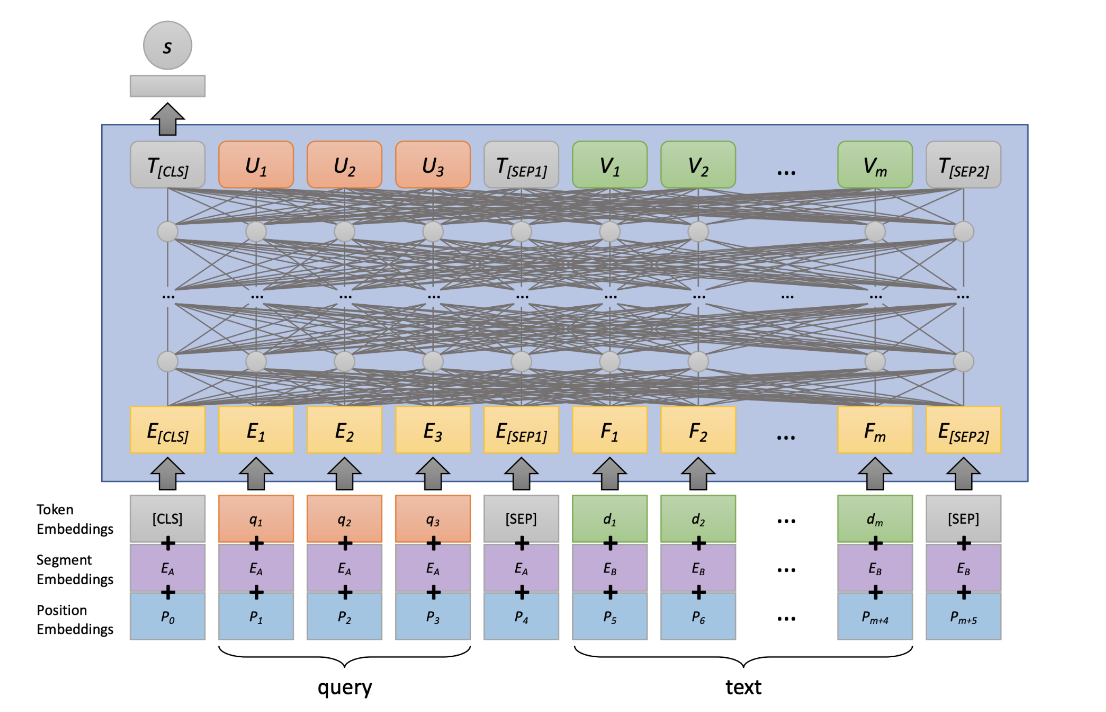 | 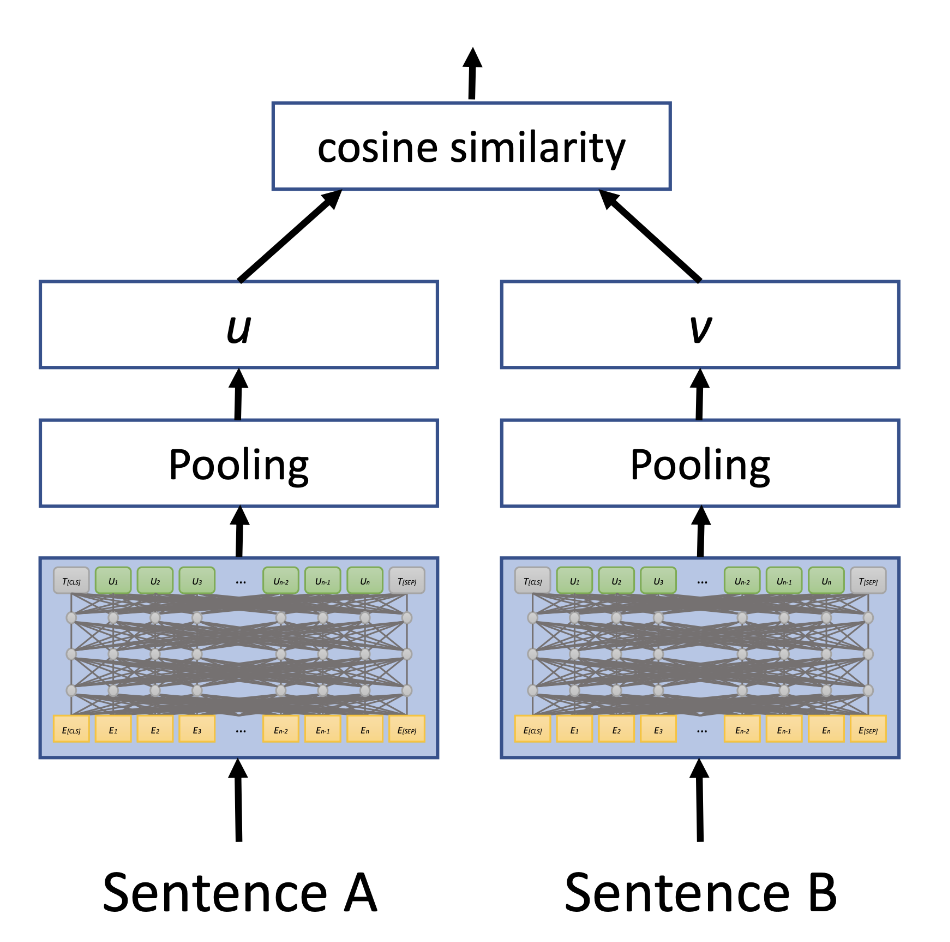 |

Выполните следующие задания:
* Внесите необходимые изменения в код и обучите xlm-roberta-base в фомате bi-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

In [43]:
# YOUR CODE HERE
class BiEncoderRankBert(nn.Module):
    def __init__(self, labels_num=3, train_layers_count=2):
        #labels_num here is embedding len
        super(BiEncoderRankBert, self).__init__()

        self.bert = AutoModel.from_pretrained("xlm-roberta-base")
        self.config = self.bert.config
        self.labels_num = labels_num

        # freeze all layers without bias and LN
        for name, par in self.bert.named_parameters():
            if 'bias' in name or 'LayerNorm' in name:
                continue
            par.requires_grad = False

        layer_count = self.config.num_hidden_layers
        for i in range(train_layers_count): #unfreeze somw layers
            for par in self.bert.encoder.layer[layer_count - 1 - i].parameters():
                par.requires_grad = True
        
        # map cls token emb to relevance score
        self.head = nn.Linear(self.config.hidden_size, self.labels_num) 
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        x = self.bert(input_ids=input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask
                      )[0][:, 0, :] #hidden_state of [CLS]
        x = self.head(x)
        return x

In [10]:
dm = VKMarcoDataModule(bienc_mode=True)
dm.prepare_data() # do nothing
dm.setup(stage='fit')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Reading df_train...
df_train is readed and formatted (removed 0-labels), time elsapsed:  355.5413770675659


In [34]:
tr = dm.df_train

In [74]:
dm = VKMarcoDataModule(df_train=tr, bienc_mode=True)
dm.df_train

,qid,label,query,text
0,1,1,0 00 дом muzono net raim feat artur adil скачать,Скачивай и слушай 🎧 raim дом o2 2018 на Zvuk.t...
1,1,3,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM feat. Artur & Adil - Дом бе...
2,1,2,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM ft. Artur & Adil - Дом в Фо...
3,1,2,0 00 дом muzono net raim feat artur adil скачать,Скачать RaiM feat. Artur & Adil - Дом в mp3 фо...
4,1,2,0 00 дом muzono net raim feat artur adil скачать,Здесь можете бесплатно скачать Дом - RaiM feat...
...,...,...,...,...
1002609,42770,1,հեպ 9 դասագիրք,28.10.2013թ Դասարանական և տնային աշխատանք Թեմա...
1002612,42770,2,հեպ 9 դասագիրք,null Toggle navigation Sovorel.am Սկիզբ Մեր մա...
1002622,42770,1,հեպ 9 դասագիրք,".AM,.ՀԱՅ,.ORG,.COM,.NET,.INFO,.GROUP և մի շարք..."
1002623,42770,1,հեպ 9 դասագիրք,Թեմա՝ Բրեստ Լիտովսկի հաշտության պայմանագիր Երբ...


## (bi-encoder) Обучение

In [64]:
class config:
    EPOCHS=1
    LR=1e-4
    WD=0.01
    SAVE_DIR="./bi_encоder_checkpoint/"
    SAVE_INTERVAL=1000
    BATCH_SIZE=64
    ACCUM_BS=1
    TRAIN_LENGTH=dm.train_length()
    DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    LOG_INTERVAL=250
    TRAIN_LAYERS=3
#     LABELS_NUM=dm.df_train['label'].nunique()
    LABELS_NUM=3
    BIENC_MODE=True

loss_fn = nn.CrossEntropyLoss()

# this instances will be initialized inside of LightningModule
bert_model = BiEncoderRankBert                           # check configure_model()
optimizer = torch.optim.AdamW                   # check configure_optimizers
scheduler = torch.optim.lr_scheduler.OneCycleLR # check configure_optimizers

In [51]:
config.SAVE_DIR="./bi_encоder_checkpoint/"

In [52]:
import gc
torch.cuda.empty_cache()
gc.collect()

4452

In [ ]:
import datetime
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
codename=f"bi_encoder__{cur_date}"
writer = SummaryWriter(f'{config.SAVE_DIR}{codename}')
lightning_model = LightningModel(bert_model,
                       amp_enable=False,
                       optim=optimizer,
                       scheduler=scheduler,
                       loss_fn=loss_fn,
                       device=config.DEVICE,
                       tb_writer=writer,
                       config=config,
                       bienc_mode=True)
checkpoint_callback = ModelCheckpoint(monitor='train_loss', dirpath=f'ckpt/{codename}', every_n_train_steps=6500)
trainer = Trainer(max_epochs=config.EPOCHS, callbacks=[checkpoint_callback])
train_dataloader = dm.simple_train_dataloader()
trainer.fit(lightning_model, train_dataloaders=train_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | CrossEntropyLoss  | 0     
1 | model   | BiEncoderRankBert | 278 M 
----------------------------------------------
21.4 M    Trainable params
256 M     Non-trainable params
278 M     Total params
1,112.184 Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

  batch 250 loss: 1.0371567120552063
  batch 250 auc: 0.5159293314491112
  batch 500 loss: 0.9889904477596283
  batch 500 auc: 0.5654750985132595
  batch 750 loss: 0.9808624901771545
  batch 750 auc: 0.5888582235578508
  batch 1000 loss: 0.9747318751811981
  batch 1000 auc: 0.5953148078933659
  batch 1250 loss: 0.9711329970359802
  batch 1250 auc: 0.6097299669922261
  batch 1500 loss: 0.967872300863266
  batch 1500 auc: 0.6125667610310462
  batch 1750 loss: 0.9625308539867401
  batch 1750 auc: 0.6158830863761541
  batch 2000 loss: 0.9548450014591217
  batch 2000 auc: 0.6152009402351768
  batch 2250 loss: 0.9583783292770386
  batch 2250 auc: 0.6202246304165576
  batch 2500 loss: 0.9605196850299835
  batch 2500 auc: 0.6199745889084014
  batch 2750 loss: 0.9534456219673156
  batch 2750 auc: 0.6241158507249965
  batch 3000 loss: 0.953892226934433
  batch 3000 auc: 0.6227317906632523
  batch 3250 loss: 0.9523677878379821
  batch 3250 auc: 0.6210454891902064
  batch 3500 loss: 0.944228754281

In [ ]:
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
last_checkpoint_name = f"{codename}_unfr={config.TRAIN_LAYERS}_epochs={config.EPOCHS}_cur={cur_date}.ckpt"
trainer.save_checkpoint(last_checkpoint_name)

## (bi-encoder) Подсчет метрик

In [48]:
dm = VKMarcoDataModule(bienc_mode=True)
dm.prepare_data() # do nothing
dm.setup(stage='test')

Reading df_test...
df_test is readed and formatted (removed 0-labels), time elapsed:  32.766791343688965


In [66]:
gc.collect()
config.SAVE_DIR="./cross_encоder_checkpoint/"
bert_model = RankBert
writer = SummaryWriter(f'{config.SAVE_DIR}')
ckpt_path = "/kaggle/input/basic-cross/basic_2024-05-03_16_00_unfr3_epochs1_2024-05-03_18_06.ckpt"

#get model from lightning module
lightning_module = load_from_model_ckpt(ckpt_path, bert_model,
                                                 amp_enable=False,
                                                 optimizer=optimizer,
                                                 scheduler=scheduler,
                                                 loss_fn=loss_fn,
                                                 writer=writer,
                                                 config=config,
                                                 )


trainer = Trainer(max_epochs=config.EPOCHS, limit_test_batches=1.)
test_dataloader = dm.test_dataloader()
trainer.test(lightning_module, dataloaders=test_dataloader)

train_layers_count type: <class 'int'> 3
labels_num type: <class 'int'> 3


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


train_layers_count type: <class 'int'> 3
labels_num type: <class 'int'> 3


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

shapes of y_test_triplet, y_true and qids:  torch.Size([146847, 3]) torch.Size([146847]) torch.Size([146847])
y_triplets: tensor([[-1.1255, -0.5290, -0.7647],
        [-1.1381, -0.5114, -0.7612],
        [-1.1263, -0.4915, -0.7599],
        [-1.1590, -0.5276, -0.7787],
        [-1.1295, -0.4909, -0.7657]])
y_true:  tensor([2, 2, 2, 1, 1])
in _compute_final_metrics: y_test <class 'torch.Tensor'> tensor([6.8108e-06, 6.8108e-06, 6.8108e-06,  ..., 6.8108e-06, 6.8108e-06,
        6.8108e-06])
in _compute_final_metrics shapes of preds, target and qids:  torch.Size([146847]) torch.Size([146847]) torch.Size([146847])
at MRR preds:  <class 'torch.Tensor'> tensor([6.8108e-06, 6.8108e-06, 6.8108e-06,  ..., 6.8108e-06, 6.8108e-06,
        6.8108e-06])
{'auc': 0.5069412894463322, 'MRR@10': tensor(0.5999), 'NDCG@10': tensor(0.4546)}


[{}]

In [ ]:
lightning_module.final_metrics

# Сравнение cross-encoder и bi-encoder архитектур \[2 балла\]

Выполните следующие задания:
* Сравните графики обучения моделей, скорость обучения и скорость инфернса.
* Напишите вывод.

### Ответ [Сравнение моделей] :
На данных графиках приведены значения метрик, время и шаги обучения трех моделей:
* amp-fp16-batch_sampler -- cross-encoder с поддержкой amp и можифицированным отбором батчей (данные группироались по длиннам);
* bi -- bi-encoder;
* cross-basic -- обычный cross-encoder без модификаций.

Все модели проходили обучение в одну эпоху с 3 размороженными слоями.

Би-энкодер обучается хуже на тех же шагах: значение auc меньше, а loss больше чем у кросс-энкодера.
Но стоит заметить, что при этом эпоха обучения прошла быстрее, у би-энкодера (хоть и сравнив метрики в одно и то же время, cross-энкодер побеждает)

По-поводу инференса картина интересная: есть замеры времени предсказания моделей на тестовом части данных, а именно `14:49` заняло у cross-encoder'а и `14:50` у bi-encoder'а. Что интересно, NDCG и там и там по прошествии одной эпохи составляет `NDCG@10=0.4546`, что на 0.0005 меньше, чем у BM25. Вероятно при дальнейшем обучении можно прийти к более высоким значениям метрикb. Показатель `MRR@10=0.6000` и `MRR@10=0.5999` у кросс- и би- энкодера соотв. превзомшли бейзлайн BM25 (у BM25 `MRR@10=0.5798`)
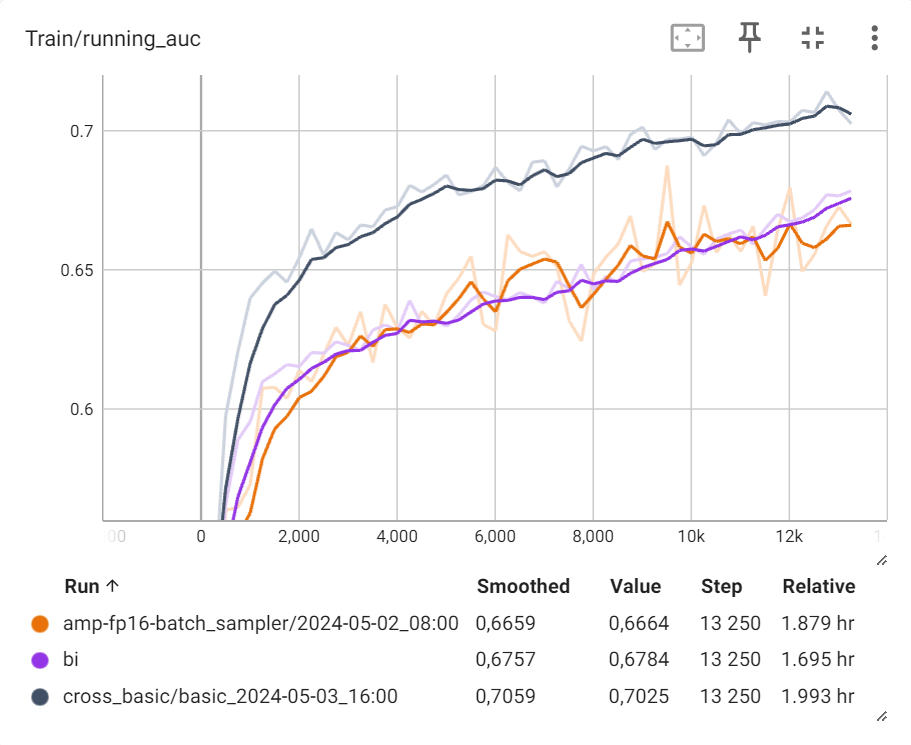
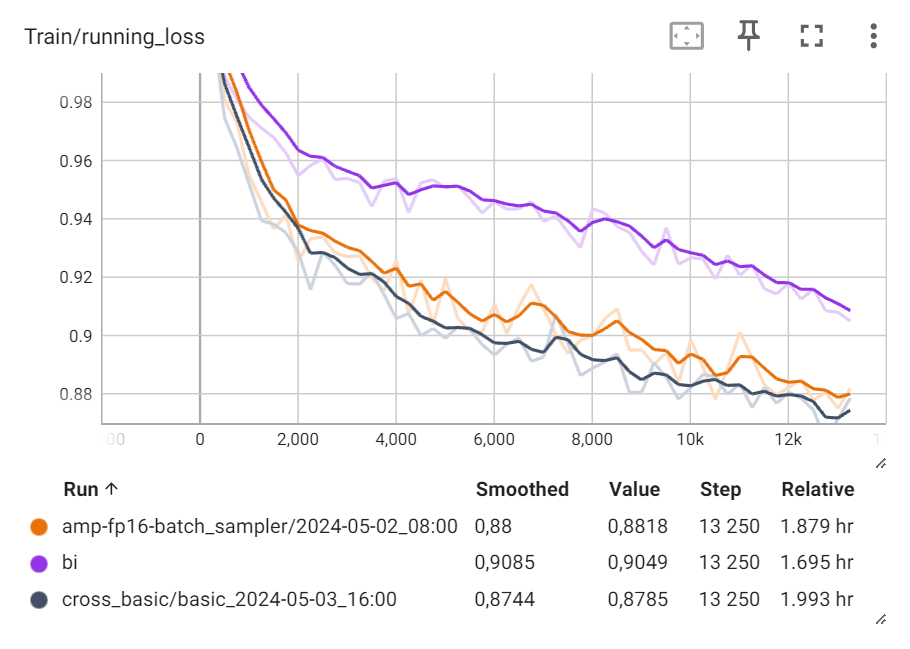

# Дополнительно \[10 баллов\]

Вы можете получить дополнительные баллы, выполнив одно или несколько заданий:
* Обучите cross-encoder в fp16 с использованием AMP, посчитайте метрики, есть ли изменения? **[1 балла]**

>Обучение проходило быстрее с AMP и семплированием батчей из следующего пункта. В данной версии ноутбука метрики вывести не удалось из-за потери чекпоинта, но есть предположение, что они за одно и то же количество шагов обучения (1 эпоха) будут меньше, из-за потери точности при вычислениях предиктов и подсчета потерь._

* Реализуйте семплирование примеров с учетом их длинны, насколько ускорилось обучение cross-encoder? **[1 балла]**

>Вместе с AMP и семплированием батчей, обучение заняло на 0.12 часа меньше (7.2 минуты). Возможно можно добиться большего ускорения, если рассмотреть более скурпулезное семплирование батчей, либо подобрать значения максимального окл-ва токенов при токенизации.

* Попробуйте увеличить метрики bi-encoder за счет использования другого претрейна. Кроме xlm-roberta-base на [Huggingface](https://huggingface.co/models) есть большое количество предобученных моделей BERT. Датасет содержит тексты на русском языке, поэтому стоит обратить внимание на русскоязычные или мультиязычные претрейны. Если вам удасться улучшить метрику, то предположите, какие отличия претрейна на это повлияли. **[2 балла]**

>NaN

* Попробуйте разморозить больше параметров модели (например, последний трансформерный слой). Как изменилось качество и скорость обучения? **[2 балла]**

>Ниже приведено обучение 4 слоев в сравнении с 3-мя обучаемыми слоями

* Попробуйте использовать listwise лосс для обучения модели, как изменились метрики? **[4 балла]**

>NaN

## Разморозим 4 последних слоя

In [41]:
# YOUR CODE HERE
config.SAVE_DIR="./cross_encоder_checkpoint/"
config.TRAIN_LAYERS=4
import datetime
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
codename=f"cross_batch-sampled_{cur_date}"
writer = SummaryWriter(f'./cross_encоder_checkpoint/{codename}')
lightning_model = LightningModel(bert_model,
                       amp_enable=False,
                       optim=optimizer,
                       scheduler=scheduler,
                       loss_fn=loss_fn,
                       device=config.DEVICE,
                       tb_writer=writer,
                       config=config,)
checkpoint_callback = ModelCheckpoint(monitor='train_loss', dirpath=f'ckpt/{codename}', every_n_train_steps=6500)
trainer = Trainer(max_epochs=config.EPOCHS, callbacks=[checkpoint_callback])
train_dataloader = dm.sampled_train_dataloader()
trainer.fit(lightning_model, train_dataloaders=train_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | model   | RankBert         | 278 M 
---------------------------------------------
28.4 M    Trainable params
249 M     Non-trainable params
278 M     Total params
1,112.184 Total estimated model params size (MB)


train_layers_count type: <class 'int'> 4
labels_num type: <class 'int'> 3


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


sorting and chunking...
sorted and chunked in 0.140


Training: |          | 0/? [00:00<?, ?it/s]

  batch 250 loss: 0.9880074090957641
  batch 250 auc: 0.5013423816722332
  batch 500 loss: 0.9805254738330841
  batch 500 auc: 0.5565092713675436
  batch 750 loss: 0.9592547707557678
  batch 750 auc: 0.5805897901731839
  batch 1000 loss: 0.9519079191684723
  batch 1000 auc: 0.5896804822606598
  batch 1250 loss: 0.9427693507671356
  batch 1250 auc: 0.6102557531551694
  batch 1500 loss: 0.9361963360309601
  batch 1500 auc: 0.627750850258048
  batch 1750 loss: 0.9278168475627899
  batch 1750 auc: 0.6051995974716248
  batch 2000 loss: 0.9309086282253265
  batch 2000 auc: 0.6181453145318215
  batch 2250 loss: 0.9179576741456985
  batch 2250 auc: 0.6179314221639146
  batch 2500 loss: 0.9187193769216537
  batch 2500 auc: 0.6336523912245083
  batch 2750 loss: 0.92776420378685
  batch 2750 auc: 0.6143673400283468
  batch 3000 loss: 0.908896675825119
  batch 3000 auc: 0.6064547201945969
  batch 3250 loss: 0.9070302684307099
  batch 3250 auc: 0.6278485840250838
  batch 3500 loss: 0.91167489457130

Exception ignored in: <function _xla_gc_callback at 0x78c09d72ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
import datetime
cur_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M").__str__()
trainer.save_checkpoint(f"{codename}_unfr={config.TRAIN_LAYERS}_epochs={config.EPOCHS}_{cur_date}.ckpt")

## Cравнение обучения с 3 размороженными слоями и с 4
Ниже приведены графики обучения кросс-энкодера с 3 размороженными слоями и кросс-энкодера с 4-мя размороженными слоями + модифицированным отбором наблюдений в батч. Модель стала слегка больше весить, но из-за особого семплироания батчей то же кол-во шагов было обучено за меньшее время.

Можно видеть, что показатель auc на половине эпохи у модели с большим количеством обучаемых слоев меньше, чем у модели с меньшим кол-вом слоев. При дальнейшем обучении, бирюзовый график должен обогнать черный по значению auc.

С loss-ом картина неоднозначна; из-за того, что пришлось повторять эксперимент в последний момент из-за потери чекпоинтов, обучение проводилось половину одной эпохи. Из вида графиков сложно сказать, к чему может привести дальнейшее обучение, может loss у модели с [unfr=4] не так быстро станет меньше, чем у модели с [unfr=3]
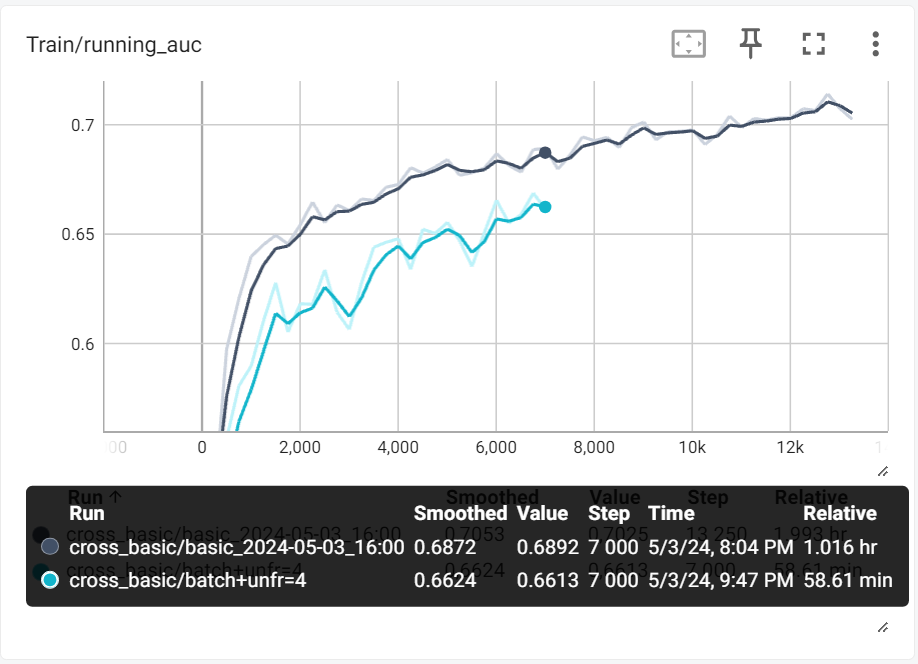
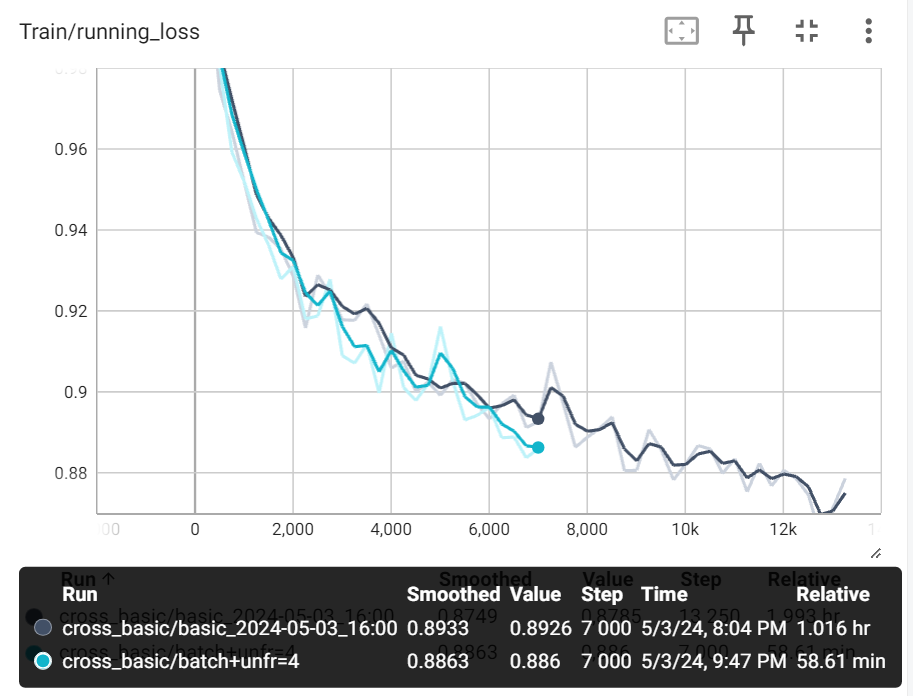

----